# Training Neural SDEs via the signature kernel scoring rule: The unconditional case

### Background. 

A <i>generative adversarial network</i> (GAN) is, broadly, a machine learning architecture which attempts to teach a generator network $G_\theta: \mathcal{Z} \to \Omega$ to learn an observed probabiity distribution $\mathbb{P}_{X^{\text{true}}} \in \mathcal{P}(\Omega)$. Here, $(\mathcal{Z}, \mathcal{B}(\mathcal{Z}))$ is a measure space equipped with some probability measure $\mathbb{P}_\mathcal{Z}$ and is often referred to as a <i>latent space</i>. 

Training is facilitated by a so-called discriminator $D_\phi: \mathcal{P}(\Omega) \times \mathcal{P}(\Omega) \to \mathbb{R}$ which serves as a critic to the output of the generator. The objective function for the generator-discriminator pair is given by

\begin{equation*}
    \mathcal{L}(\theta) = \min_\theta \max_\phi D_\phi(\mathbb{P}_{X^\theta}, \mathbb{P}_{X^{\text{true}}}) + \lambda ||\theta||_{L^2},
\end{equation*}

where $\mathbb{P}^\theta = {G_\theta}_{\#}\mathbb{P}_\mathcal{Z}$ is the pushforward measure, and the final term is a regularisation penalty on the weights of the discriminator. 

### Training Neural SDEs via signature kernel scoring rules. 

We propose a generator-discriminator pair consisting of a neural SDE (NSDE) and the signature kernel scoring rule $\phi_{\text{sig}}$. The generator $G_\theta: \mathcal{Z} \to C([0, T]; \mathbb{R}^x)$ is given by the solution to the SDE 

\begin{align*}
    dY_t &= \mu_\theta(t, Y_t)dt + \sigma_\theta(t, Y_t)\circ dW_t, \\ 
    Y_0  &= \xi_\theta(V), \\
    X_t  &= \pi_\theta(Y_t),
\end{align*}

where $V \sim \mathbb{P}_\mathcal{V}$ is some starting $v$-dimensional noise, $\xi_\theta: \mathbb{R}^v \to \mathbb{R}^y$ a linear layer, $\mu_\theta: [0, T] \times \mathbb{R}^y \to \mathbb{R}^y$ and $\sigma_\theta: [0, T] \times \mathbb{R}^y \to \mathbb{R}^{y \times w}$ are feedforward networks, and $\pi_\theta: \mathbb{R}^y \to \mathbb{R}^x$ is a linear layer. Solutions to the the SDE take values in $\mathbb{R}^y$ - latent space - and the transformed back to the required target space. Here, $\mathcal{Z} = \mathcal{V} \times C([0, T]; \mathbb{R}^w)$. In this way $\mathbb{P}_\theta = {G_\theta}_{\#}({\mathbb{P}_\mathcal{V} \times \mathbb{W}})$, where $\mathbb{W}$ is the Wiener measure.

The discriminator is given by the signature kernel scoring rule 

\begin{equation*}
        \phi_{\text{sig}}(\mathbb{P}, y) := \mathbb{E}_{x, x' \sim \mathbb{P}}[k_{\text{sig}}(x, x')] - 2\mathbb{E}_{x \sim \mathbb{P}}[k_{\text{sig}}(x, y)],
\end{equation*}

and we train non-adversarially by seeking to minimise the loss over the expected scoring rule 

\begin{equation*}
   \min_\theta \mathcal{L}(\theta) \quad \text{where} \quad \mathcal{L}(\theta) = \mathbb{E}_{y\sim \mathbb P_{X^{\text{true}}}}[\phi_{\text{sig}}(\mathbb P_{X^\theta}, y)].
\end{equation*}

This is equivalent to training with respect to the maximum mean discrepancy (MMD) associated to the signature kernel $k_{\text{sig}}$. 

<b>A note about adversariality</b>. Classical MMD-GANs seek adversarialise the learning problem by parametrizing the kernel as a neural network. We note that our results can be achieved without any form of adversarialization. However, if one wishes to train adversarially, we include the option to via adversarializing the path scaling parameter. This can be implemented by setting the <code>adversarial</code> variable to <code>True</code> in the configuration section. Adversarial training in this manner only works for the signature kernel-based training methods.

In [1]:
%load_ext autoreload
%autoreload 2
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim.swa_utils as swa_utils
from IPython import display
from tqdm import tqdm

from src import rBergomi
from src.gan import sde
from src.gan.base import (
    preprocess_real_data,
    get_real_data,
    get_synthetic_data,
    get_scheduler,
    stopping_criterion,
    evaluate_loss
)
from src.gan.discriminators import SigKerMMDDiscriminator, TruncatedDiscriminator, CDEDiscriminator
from src.gan.generators import Generator
from src.gan.output_functions import plot_loss, plot_results
from src.utils.helper_functions.data_helper_functions import subtract_initial_point
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.helper_functions.plot_helper_functions import make_grid
from src.utils.transformations import Transformer

# import scienceplots
# plt.style.use("science")
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']  = 22

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# import pandas as pd
# df = pd.read_csv('./data/forex_data/SPX_H1.csv')
# #rename columns
# df.rename(columns={'spx': 'Open', 'Date': 'Time'}, inplace=True)
# df['Time'] = pd.to_datetime(df['Time'])
# df.to_csv('./data/forex_data/SPX_H1.csv', index=False, sep='\t')

In [3]:
torch.manual_seed(0)

### Layout. 

This notebook is broken into four sections: 

1) <b>Data:</b> The measure to be learnt on pathspace. Currently we support training a gBm, rBergomi model, or foreign exchange data. 

2) <b>Generator:</b> This will always be a neural SDE.

3) <b>Discriminator:</b> There are three options here. The first is our Sig-MMD. The second is the truncated, linear MMD used in "Sig-Wasserstein GANs for time series generation" (Ni et al., 2021). The third is the Wasserstein distance from "Neural SDEs as infinite-dimensional GANs" (Kidger et al., 2021). 

4) <b>Training the NSDE and evaluation:</b> The NSDE is then trained. Perfomance evaluation can be found in the requisite notebooks.

In [4]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'

if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

# You realistically need GPU access (either natively or via cloud computing) to run this notebook.

## 0. Configuration

This is the universal configuration which sets the data loading, generator and discriminator hyperparameters, training types, and so on. Each value is annotated.

In [5]:
### Data arguments
## Data hyperparameters
output_dim          = 1               # Dimension of the outputs.
batch_size          = 38             # Size of minibatches when training.
path_length         = 250              # Number of timesteps in paths.
dataset_size        = batch_size*3  # Number of paths in the train/test datasets.
normalisation       = "mean_var"      # How to transform paths. Options are None, "mean_var", "min_max"
scale               = 1e0             # Float scale to each path dimension.

## Data generation/dataset arguments
data_type             = "forex"                           # Choice of "gbm", "rBergomi", "forex".

forex_pairs           = ["SPX"]            # "EURUSD", "USDJPY", "BTCUSD", "BRENTCMDUSD"
stride_length         = 50                               # Number of timesteps to stride when creating path data.
frequency             = "H1"                            # Choice of "H1", "M15", "M30"
filter_extremal_paths = False                           # Filter out extremal values (by tv and terminal value)
filter_extremal_pct   = 0.95                            # Quantile to filter out, if the above is TRUE
end_time              = 2                               # End time to simulate until (synthetic examples only)
tt_split              = 1.0                             # Train/test split


gbm_params               = [0., 0.2]
rB_params                = [0.2**2, 1.5, -0.7, 0.2]
cond_                    = data_type == "rBergomi"

sde_parameters           = gbm_params if cond_ else rB_params
gen_sde_dt_scale         = 1e-1                         # Refine the partitioning of SDE solver that generates data.
gen_sde_integration_type = "ito"                        # Definition of stochastic integration for data generator
gen_sde_method           = "srk"                        # Integration method

learning_type            = "paths"                      # Paths or returns.
time_add_type            = "realistic"                      # "Basic": (0, 1, ...). "Realistic": actual change (in years)
filter_by_time           = True                         # In the case of real data, whether to filter out missampled paths
initial_point            = "scale"                      # How to handle initial point normalisation. "scale" or "translate"

### Path transformation types/arguments
do_transforms            = True  # Whether to apply path transformations

transformations     = OrderedDict([
    ("visibility"        , False),
    ("time_difference"   , False),
    ("time_normalisation", False),     # Set this to FALSE when training wrt wasserstein_cde.
    ("lead_lag"          , True),
    ("basepoint"         , False)
])

transformation_args = OrderedDict([
    ("visibility"        , {}),
    ("time_difference"   , {}),
    ("time_normalisation", {}),
    ("lead_lag"          , {
        "time_in"           : True,
        "time_out"          : False,
        "time_normalisation": False
    }),
    ("basepoint"         , {})
])

subtract_start = True  # Subtract initial point before calculating loss. You almost always want this to be true.

### Generator arguments
generator_config = {
    "initial_noise_size" : 5,                 # How many noise dimensions to sample at the start of the SDE.
    "noise_size"         : 8,                 # How many dimensions the Brownian motion has.
    "hidden_size"        : 16,                # Size of the hidden state of the generator SDE.
    "mlp_size"           : 64,                # Size of the layers in the various MLPs.
    "num_layers"         : 3,                 # Numer of hidden layers in the various MLPs.
    "activation"         : "LipSwish",        # Activation function to use over hidden layers
    "tanh"               : True,              # Whether to apply final tanh activation
    "tscale"             : 1,                 # Clip parameter for tanh, i.e. [-1, 1] to [-c, c]
    "fixed"              : True,              # Whether to fix the starting point or not
    "noise_type"         : "general",         # Noise type argument for torchsde
    "sde_type"           : "ito",             # SDE integration type from torchsde
    "dt_scale"           : 1e0,               # Grid shrinking parameter. Lower values are computationally more expensive
    "integration_method" : "euler"            # Integration method for torchsde
}

### Discriminator args
discriminator_type = "sigker_mmd"   # Options are "sigker_mmd", "wasserstein_cde", "truncated_mmd"
adversarial        = False          # Whether to adversarially train the discriminator or not.
clip_disc_param    = False          # MMD-based discriminators only: whether to ensure the scaling param stays above 1


## sigker_mmd args
sigker_mmd_config = {
    "dyadic_order"   : 1,         # Mesh size of PDE solver used in loss function
    "kernel_type"    : "rbf",     # Type of kernel to use in the discriminator
    "sigma"          : 1.0,       # Sigma in RBF kernel
    "use_phi_kernel" : False,     # Whether to use the the phi(k) = (k/2)! scaling. Set "kernel_type" to "linear".
    "n_scalings"     : 3,         # Number of samples to draw from Exp(1). ~8 tends to be a good choice.
    "max_batch"      : 16         # Maximum batch size to pass through the discriminator.
}

## truncated_mmd args
truncated_mmd_config = {
    "order"         : 6,         # Truncation level
    "scalar_term"   : False,     # Whether to include the leading 1 term in the signature.
}


## wasserstein_ode args
wasserstein_cde_config = {
    "hidden_size" : 16,          # Number of hidden states in CDE solver
    "num_layers"  : 3,           # Number of layers in MLPs of NCDE
    "mlp_size"    : 32           # Number of neurons in each layer
}

### Training hyperparameters
## Optimizer parameters
generator_lr     = 1e-4         # Generator initial learning rate
discriminator_lr = None         # Discriminator initial learning rate
steps            = 4000          # How many steps to train both generator and discriminator for.
init_mult1       = 1             # Changing the initial parameter size can help.
init_mult2_dr    = 5e-1          # Changing vector field MLP initial parameter size.
init_mult2_df    = 5e-1          # Changing vector field MLP initial parameter size.
init_mult3       = 1             # Initial parameter size for discriminator.
weight_decay     = 1e-2          # Weight decay (regularizing term).
swa_step_start   = int(steps/2)  # When to start using stochastic weight averaging (L2).
gen_optim        = "Adam"        # Optimiser type for generator
disc_optim       = "Adadelta"    # Optimiser type for discriminator
loss_evals       = 1             # Number of times to evaluate the loss before performing an optimizer step

## Annealing learning rate parameters
adapting_lr            = False          # Whether to make the learning rate adaptive.
adapting_lr_type       = "OneCycleLR"   # LR scheduler type
lambda_lr_const        = 0.5            # If LambdaLR, learning rate fraction to reduce to
poly_exponent_smoother = -0.5           # If LambdaLR, poly exponent to decrease to
mult_const             = 1.01           # If MultiplicativeLR, val of a for \eta_{t+1} = a\eta_t
gamma_lr               = 0.25           # If StepLR, multiplier for learning rate
steps_lr               = int(steps/10)  # If StepLR, when to change learning rate
max_lr                 = 1e-06          # OneCycleLR: Maximum rate
anneal_strategy        = "cos"          # OneCycleLR: Anneal type
total_steps            = steps          # OneCycleLR: Anneal rate
pct_start              = 0.3            # OneCycleLR: Percentage of schedule increasing rate
div_factor             = 10             # OneCycleLR: Final lr as a percentage of max

## Early stopping
early_stopping_type = "marginals"  # Early stopping type ('marginals' or 'mmd')
crit_evals          = 20           # Marginals: number of evaluations of criterion
crit_thresh         = 0.99         # Marginals: stopping threshold
cutoff              = 1.           # Marginals: cutoff of marginal distributions to remove extremal values
mmd_ci              = 0.95         # mmd: Confidence on null distribution
mmd_atoms           = steps_lr     # mmd: number of atoms to build null distribution
mmd_periods         = 50           # mmd: number of lagged periods to compare threshold to

## Evaluation and plotting hyperparameters
steps_per_print  = int(steps/400)              # How often to print the loss.
num_plot_samples = int(batch_size/2)          # How many samples to use on the plots at the end.
plot_locs        = (0.1, 0.3, 0.5, 0.7, 0.9)  # Plot some marginal distributions at this proportion of the way along.

## 1. Data

We begin by pre-loading and setting data arguments. If real data is being used, some preprocessing needs to be completed so the data is in the right form to be wrapped as <code>torch</code> dataloader objects.

In [8]:
# If real data, needs to be loaded prior to being packaged up.

data_kwargs = {
    "dataset_size" : dataset_size,
    "path_length"  : path_length,
    "batch_size"   : batch_size,
    "step_size"    : stride_length,
    "learning_type": learning_type,
    "time_add_type": time_add_type,
    "initial_point": initial_point,
    "train_test_split": tt_split
}

real_data_kwargs = {
    "pairs"                : forex_pairs,
    "frequency"            : frequency,
    "filter_extremal_paths": filter_extremal_paths,
    "filter_extremal_pct"  : filter_extremal_pct

}

if data_type.lower() == "forex":  # Real data arguments
    np_train_data, np_test_data, train_df = preprocess_real_data(data_kwargs, real_data_kwargs)

    ts, data_size, train_dataloader, means, stds = get_real_data(
        np_train_data,
        batch_size,
        dataset_size,
        device,
        time_add_type  = time_add_type,
        normalisation  = normalisation,
        filter_by_time = filter_by_time,
        initial_point  = False,
        scale          = scale
    )

    # _, _, test_dataloader = get_real_data(
    #     np_test_data,
    #     batch_size,
    #     dataset_size,
    #     device,
    #     time_add_type  = time_add_type,
    #     normalisation  = normalisation,
    #     filter_by_time = filter_by_time,
    #     initial_point  = False,
    #     scale          = scale
    # )

elif data_type.lower() in ["gbm", "rbergomi"]:

    sdeint_kwargs = {
        "sde_method":   gen_sde_method,
        "sde_dt_scale": gen_sde_dt_scale
    }

    if data_type.lower() == "gbm":
        sde_gen = sde.GeometricBrownianMotion(gen_sde_integration_type, "diagonal", *sde_parameters)
    elif data_type.lower() == "rbergomi":
        xi, eta, rho, H = sde_parameters
        sde_gen = rBergomi(n=int(path_length/end_time), N=dataset_size, T=end_time, a=H-0.5, rho=rho, eta=eta, xi=xi)

    ts, data_size, train_dataloader = get_synthetic_data(
        sde_gen,
        batch_size,
        dataset_size,
        device,
        output_dim,
        path_length,
        normalisation = normalisation,
        scale         = scale,
        sdeint_kwargs = sdeint_kwargs,
        end_time      = end_time,
        time_add_type = time_add_type
    )

    _, _, test_dataloader = get_synthetic_data(
        sde_gen,
        batch_size,
        dataset_size,
        device,
        output_dim,
        path_length,
        normalisation = normalisation,
        scale         = scale,
        sdeint_kwargs = sdeint_kwargs,
        end_time      = end_time,
        time_add_type = time_add_type
    )

infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

transformer               = Transformer(transformations, transformation_args, device).to(device) if do_transforms else lambda x: x

In [9]:
np_train_data[72,:,0]*365

array([  0.,   1.,   5.,   6.,   7.,   8.,   9.,  12.,  13.,  14.,  15.,
        16.,  19.,  20.,  21.,  22.,  23.,  26.,  27.,  28.,  29.,  30.,
        33.,  34.,  35.,  36.,  37.,  40.,  41.,  42.,  43.,  44.,  48.,
        49.,  50.,  51.,  54.,  55.,  56.,  57.,  58.,  61.,  62.,  63.,
        64.,  65.,  68.,  69.,  70.,  71.,  72.,  75.,  76.,  77.,  78.,
        79.,  82.,  84.,  85.,  86.,  89.,  90.,  91.,  92.,  93.,  96.,
        97.,  98.,  99., 100., 103., 104., 105., 106., 107., 110., 111.,
       112., 113., 114., 117., 118., 119., 120., 121., 124., 125., 126.,
       127., 128., 131., 132., 133., 134., 135., 138., 139., 140., 141.,
       142., 146., 147., 148., 149., 152., 153., 154., 155., 156., 159.,
       160., 161., 162., 163., 166., 167., 168., 169., 170., 173., 174.,
       175., 176., 177., 180., 181., 182., 183., 184., 187., 188., 189.,
       190., 191., 194., 195., 196., 197., 198., 201., 202., 203., 204.,
       205., 208., 209., 210., 211., 212., 215., 21

### A note about normalisation and scaling.

Scaling and normalising the initial data is a very important consideration. Heuristically, this is for the following reasons:

1) <b>The signature kernel PDE</b>. Accurate gradients are required when backpropagating through the discriminator, which as mentioned is the MMD associated to the signature kernel. The signature kernel is the solution to a PDE, where solutions are more "accurate" in practice when the state space traversed is of lower numerical order.

2) <b>Distribution of signature terms in the data</b>. The signature kernel is a dot product in $T((\mathbb{R}^d))$ between expected signature terms. Reducing the MMD loss between two groups of paths can be thought of as reducing this dot product. If a certain order of terms in the signature is too large relative to the others, then it is unlikely other moments will be learnt when backpropagting. For example, if the first order terms are too large (the "drift"), then path increments will be learnt at the cost of other moments. If higher-order terms dominate, then lower-order terms are not learnt.  

3) <b>Initial distribution of generator</b>. Changing scalings and normalisations will change the initial distribution of paths given by the generator. A quick visual plot should be enough for one to check if the size of the generator's parameters are appropriate for the given problem. The parameter <code>init_mult2</code> is the one to focus on here.

In [10]:
STUDY_SIGNATURE_TERMS = False

if STUDY_SIGNATURE_TERMS:

    sigmas      = sigker_mmd_config.get("sigma")
    kernel_type = sigker_mmd_config.get("kernel_type")

    pow_func = lambda x, y: torch.pow(x, y)/math.factorial(y)
    bnd_func = lambda x, y: pow_func(torch.max(torch.sum(torch.abs(torch.diff(x, axis=1)), axis=1)), y)

    do_theo_bnd = False

    with torch.no_grad():

        paths,     = next(infinite_train_dataloader)
        _, _, dims = paths.shape
        dims -= 1

        paths = paths.cpu()

        if not isinstance(sigmas, list):
            sigmas = np.array([sigmas])

        for k in range(dims):
            ex_title = f", dim = {k+1}" if dims != 1 else ""

            fig, axes = plt.subplots(1, len(sigmas), figsize=(6*len(sigmas), 3))

            if len(sigmas) == 1:
                axes = np.array([axes])

            for ax, sig in zip(axes, sigmas):

                ex_sig = f", sigma = {sig}" if kernel_type =="rbf" else ""

                increments        = torch.abs(paths[:, -1, k+1] - paths[:, 0, k+1])
                scaled_increments = increments/np.sqrt(sig) if kernel_type == "rbf" else increments

                powers = np.arange(1, 10).astype(int)

                moment_terms = torch.tensor([[pow_func(inc, d) for d in powers] for inc in scaled_increments])
                moment_means = moment_terms.mean(axis=0)
                moment_stds  = moment_terms.std(axis=0)

                ax.plot(powers, moment_means, color="dodgerblue", alpha=0.75, label="moment_means")
                if do_theo_bnd:
                    level_bds    = [bnd_func(paths[..., k+1], d) for d in powers]
                    ax.plot(powers, level_bds, color="tomato", linestyle="dashed", alpha=0.75, label="theo_bnd")

                ax.fill_between(powers, moment_means-moment_stds, moment_means+moment_stds, color="dodgerblue", alpha=0.25)
                make_grid(axis=ax)
                ax.set_title("Scaled increment values (moment ratio)" + ex_sig + ex_title, fontsize="small")
                ax.legend(fontsize="small");

## 2. Generator

As mentioned in the introduction, the generator is given by a neural SDE.

In [11]:
generator = Generator(data_size=data_size, **generator_config).to(device)

with torch.no_grad():
    if (not generator_config.get("fixed")) or (learning_type == "returns"):
        for prm in generator._initial.parameters():
            prm = prm*init_mult1

    for name, prm in generator._func.named_parameters():
        if "_drift" in name:
            prm.data*=init_mult2_dr
        else:
            prm.data*=init_mult2_df

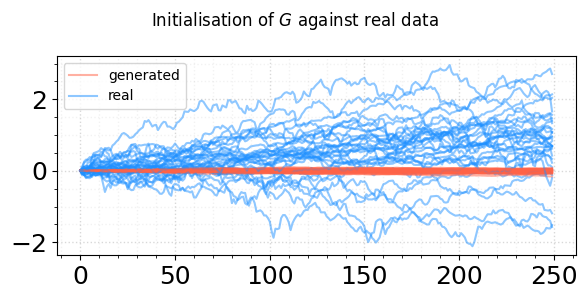

In [12]:
CHECK_INIT_GENERATOR = True

if CHECK_INIT_GENERATOR:

    dims = output_dim if data_type != "forex" else len(forex_pairs)

    fig, axes = plt.subplots(dims, 1, figsize=(6, dims*3))

    with torch.no_grad():
        y, = next(infinite_train_dataloader)
        x  = generator(ts, batch_size)

        if subtract_start:
            y  = subtract_initial_point(y)
            x  = subtract_initial_point(x)

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for k, ax in enumerate(axes):

        N = 32
        x_plot = x[:N, :, k+1].cpu()
        y_plot = y[:N, :, k+1].cpu()

        generated_first = True
        real_first      = True

        for xi, yi in zip(x_plot, y_plot):
            g_kwargs = {"label": "generated"} if generated_first else {}
            r_kwargs = {"label": "real"} if generated_first else {}

            ax.plot(xi, color="tomato", alpha=0.5, **g_kwargs)
            ax.plot(yi, color="dodgerblue", alpha=0.5, **r_kwargs)

            generated_first = False
            real_first      = False

        ax.legend()
        make_grid(axis=ax)
        ax_title = "" if dims == 1 else f"Dim {k+1}"
        ax.set_title(ax_title, fontsize="small")
    fig.suptitle("Initialisation of $G$ against real data")
    plt.tight_layout()

## 3. Discriminator

We have three options here - the signature kernel MMD, the truncated MMD (Ni et al, 2021), and the Wasserstein distance as witnessed by a neural ODE (Kidger et al, 2021).

In [13]:
if discriminator_type.lower() == "sigker_mmd":
    discriminator = SigKerMMDDiscriminator(
        path_dim     = data_size,
        adversarial  = adversarial,
        **sigker_mmd_config
    ).to(device)

elif discriminator_type.lower() == "truncated_mmd":
    discriminator = TruncatedDiscriminator(
        path_dim    = data_size,
        adversarial = adversarial,
        **truncated_mmd_config
    ).to(device)

elif discriminator_type.lower() == "wasserstein_cde":
    discriminator = CDEDiscriminator(
        data_size = data_size,
        **wasserstein_cde_config
    ).to(device)
else:
    discriminator = None
    print("Discriminator does not exist.")

### A note about the sigma scaling parameter, and the distribution of the MMD.


It is helpful to "calibrate" the starting sigma, for the same reasons mentioned in the above note.

In [14]:
GENERATE_NULL_MMD = False

if GENERATE_NULL_MMD and (discriminator_type != "wasserstein_cde"):
    with torch.no_grad():
        mmd_atoms = batch_size
        true_mmds = np.zeros(mmd_atoms)

        for i in tqdm(range(mmd_atoms)):
            x, = next(infinite_train_dataloader)
            y, = next(infinite_train_dataloader)

            if subtract_start:
                x = subtract_initial_point(x)
                y = subtract_initial_point(y)

            x = transformer(x)
            y = transformer(y)

            true_mmds[i] = discriminator(x, y.detach())

        ci = sorted(true_mmds)[int(mmd_ci*mmd_atoms)]

        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        plt.hist(sorted(true_mmds), bins=int(mmd_atoms/10), alpha=0.6, color="dodgerblue", density=True)
        make_grid()
        print(f"{100*mmd_ci:.0f}% CI: {ci:.5e}")

## 4. Optimisers and learning rate annealers

Here we define optimisers for the generator (or the discriminator), and some learning rate annealers.

In [15]:
averaged_generator     = swa_utils.AveragedModel(generator)
averaged_discriminator = swa_utils.AveragedModel(discriminator)

generator_optimiser     = getattr(torch.optim, gen_optim)(
    generator.parameters(), lr=generator_lr, weight_decay=weight_decay
)

generator_optimiser.zero_grad()

if adversarial or (discriminator_type == "wasserstein_cde"):
    discriminator_optimiser_ = getattr(torch.optim, disc_optim)
    if discriminator_type == "weighted_sigker":
        discriminator_optimiser = discriminator_optimiser_([
            {'params': discriminator._sigma},
            {'params': discriminator._weights, "lr": discriminator_lr*5e3}
        ], lr=discriminator_lr, weight_decay=weight_decay)

    discriminator_optimiser = discriminator_optimiser_(
        discriminator.parameters(), lr=discriminator_lr, weight_decay=weight_decay
    )

    discriminator_optimiser.zero_grad()
else:
    discriminator_optimiser = None

if adapting_lr:
    if adapting_lr_type == "LambdaLR":
        f_lmd = lambda epoch: (1-lambda_lr_const)*np.power(epoch + 1., poly_exponent_smoother) + lambda_lr_const
        adpt_kwargs = {"lr_lambda": f_lmd}
    elif adapting_lr_type == "StepLR":
        adpt_kwargs = {"gamma": gamma_lr, "step_size":steps_lr}
    elif adapting_lr_type == "MultiplicativeLR":
        adpt_kwargs = {"lr_lambda": lambda epoch: mult_const}

    elif adapting_lr_type == "OneCycleLR":
        adpt_kwargs = {
            "max_lr": max_lr,
            "total_steps": total_steps,
            "pct_start": pct_start,
            "anneal_strategy": anneal_strategy,
            "div_factor": div_factor
        }

    g_scheduler, d_scheduler = get_scheduler(
        generator_optimiser,
        discriminator_optimiser,
        adapting_lr_type,
        adversarial,
        **adpt_kwargs
    )

## 5. Training and evaluation

We are now ready to proceed with training the GAN/moment-matching network, and evaluate its performance. 

The generator/discriminator pairs are saved when training is complete (and tagged appropriately) for future use.

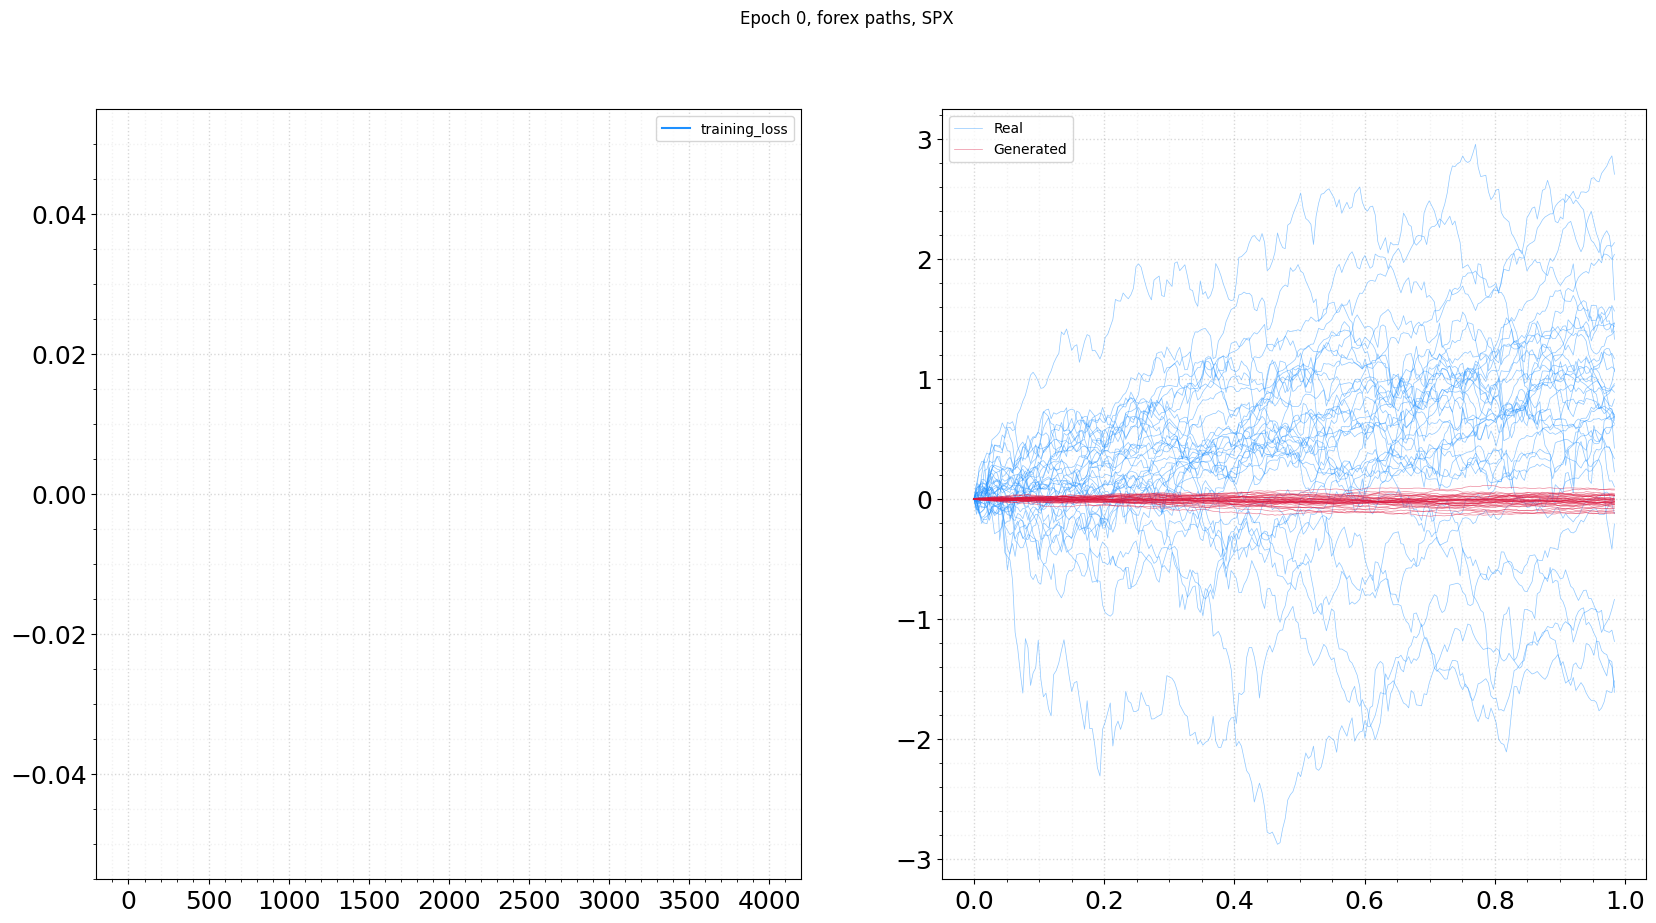

  0%|          | 0/4000 [00:21<?, ?it/s]


KeyboardInterrupt: 

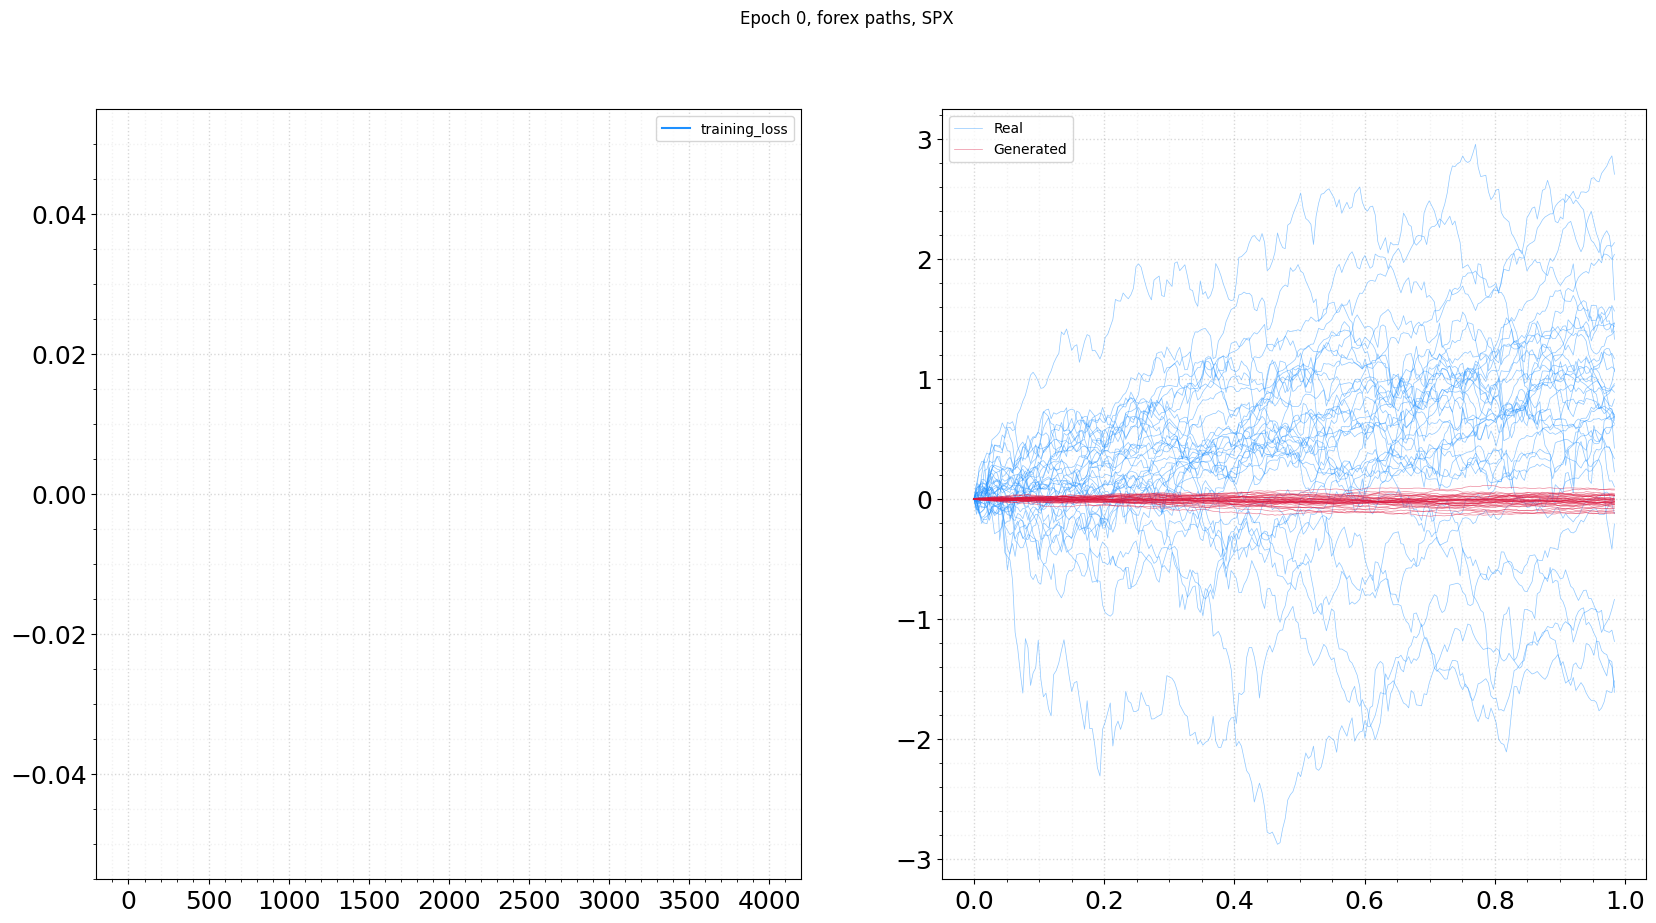

In [16]:
# Training procedure
TRAIN_MODEL      = True
update_plots     = True  # See how training is going in real time.
update_freq      = steps_per_print
num_plot_samples = batch_size
log_scale        = False  # Whether to plot the log-loss (WARNING: if negative, plot will look odd.)
plot_times       = ts.cpu() if (end_time is None) or (data_type == "forex") else torch.linspace(0, end_time, path_length)

sigmas           = torch.zeros((steps, data_size))
#weights          = torch.zeros((steps, len(_weights)))

do_total_loss    = False  # Compute total loss on dataset when printing progressive results.
ttl_loss_flag    = bool(discriminator_type == "wasserstein_cde")

step_vec     = np.arange(steps)
av_loss      = torch.zeros(steps, requires_grad=False, dtype=torch.float32)
burn_counter = 0
scaling_chg = []

gen_fp = get_project_root().as_posix() + f"/saved_models/generators/{forex_pairs[0]}_{path_length}_{batch_size}_{output_dim}_{discriminator_type}_{sigker_mmd_config['sigma']}"
disc_fp = get_project_root().as_posix() + f"/saved_models/discriminators/{forex_pairs[0]}_{path_length}_{batch_size}_{output_dim}_{discriminator_type}_{sigker_mmd_config['sigma']}"

if TRAIN_MODEL:
    tr_loss = torch.zeros(steps, requires_grad=False).to(device)
    criterions = []

    trange = tqdm(range(steps), position=0, leave=True)

    for step in trange:

        ###############################################################################
        ## 1. Calculate loss
        ###############################################################################

        real_samples,     = next(infinite_train_dataloader)
        real_samples      = transformer(real_samples).float()

        generated_samples = generator(ts, batch_size)
        generated_samples = transformer(generated_samples)

        if subtract_start:
            real_samples      = subtract_initial_point(real_samples)
            generated_samples = subtract_initial_point(generated_samples)

        if discriminator_type == "wasserstein_cde":
            gen_score  = discriminator(generated_samples)
            real_score = discriminator(real_samples)
            loss       = gen_score - real_score
        else:
            loss = discriminator(generated_samples, real_samples.detach())

        loss.backward()

        tr_loss[step] += loss.detach().clone()
        burn_counter  += 1

        # Stepped sig_ker discriminator: changing the scaling factor
        if False:
            with torch.no_grad():
                if step < _change_window:
                    av_loss[step] = tr_loss[step].item()
                    st_ind = step
                else:
                    st_ind = int(step-_change_window)
                    av_loss[step] = torch.mean(tr_loss[st_ind:step]).item()

                # Changing the scaling factor
                if (discriminator_type == "stepped_sigker") and (burn_counter >= _burn_in):
                    # Check the exit condition
                    if (av_loss[step]/av_loss[st_ind] - 1 > _change_threshold) and (step >= _burn_in):
                        curr_scaling = discriminator._scaling
                        discriminator.set_scaling(curr_scaling**2 + _change_factor)
                        scaling_chg.append(step)
                        burn_counter = 0

        ###############################################################################
        ## 2. Plotting temporal results
        ###############################################################################

        if (update_plots) and ((step % update_freq == 0) or (step == steps-1)):
            with torch.no_grad():
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

                # Plot updated loss
                #with torch.no_grad():
                np_tr_loss = tr_loss.cpu().numpy()

                current_loss  = np_tr_loss[:step]
                future_loss   = 0. if current_loss.size == 0 else current_loss.min() - np.std(current_loss)
                current_steps = step_vec[:step]
                future_steps  = step_vec[step:]
                future_loss   = np.array([future_loss for _ in range(future_steps.shape[0])])

                ax1.plot(current_steps, current_loss, alpha=1., color="dodgerblue", label="training_loss")
                ax1.plot(future_steps, future_loss, alpha=0.)

                if adapting_lr and (adapting_lr_type == "StepLR"):
                    lr_changes = np.array([steps_lr*(i+1) for i in range(int(step/steps_lr))])
                    lr_plot = True
                    for lr_c in lr_changes:
                        kwargs = {"label": "lr_change"} if lr_plot else {}
                        ax1.axvline(lr_c, linestyle="dashed", alpha=0.5, color="grey", **kwargs)
                        lr_plot = False

                if (discriminator_type == "stepped_sigker"):
                    sc_label = True
                    for sc in scaling_chg:
                        kwargs = {"label": "scaling_change"} if sc_label else {}
                        ax1.axvline(sc, linestyle="dashed", alpha=0.5, color="grey", **kwargs)
                        sc_label = False

                if log_scale:
                    ax1.set_yscale("log")

                make_grid(axis=ax1)
                ax1.legend()

                if do_transforms:
                    real_plot_samples          = transformer.backward(real_samples).cpu()
                    generated_plot_samples = transformer.backward(generated_samples).cpu()
                else:
                    real_plot_samples = real_samples.cpu()
                    generated_plot_samples = generated_plot_samples.cpu()

                if subtract_start:
                    real_plot_samples      = subtract_initial_point(real_plot_samples)
                    generated_plot_samples = subtract_initial_point(generated_plot_samples)

                this_dim = np.random.randint(1, data_size + 1)

                real_times             = real_plot_samples[..., 0]
                real_plot_times        = real_times[:num_plot_samples]
                real_plot_samples      = real_plot_samples[:num_plot_samples, :, this_dim]
                generated_plot_samples = generated_plot_samples[:num_plot_samples, :, this_dim]
                real_first      = True
                generated_first = True
                for i, real_sample_ in enumerate(real_plot_samples):
                    kwargs = {'label': 'Real'} if real_first else {}
                    ax2.plot(plot_times, real_sample_.cpu(), color='dodgerblue', linewidth=0.5, alpha=0.5, **kwargs)
                    real_first = False
                for generated_sample_ in generated_plot_samples:
                    kwargs = {'label': 'Generated'} if generated_first else {}
                    ax2.plot(plot_times, generated_sample_.cpu(), color='crimson', linewidth=0.5, alpha=0.5, **kwargs)
                    generated_first = False
                ax2.legend()
                ax2.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
                ax2.minorticks_on()
                ax2.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)

                cont_title = f"Epoch {step}, {data_type} paths"
                extr_title = f", {forex_pairs[int(this_dim-1)]}" if data_type == "forex" else ""

                fig.suptitle(cont_title + extr_title)

                display.clear_output(wait=True)
                display.display(plt.gcf())

        ###############################################################################
        ## 3. Step through optimisers and adapting LR schedulers, stochastic weights
        ###############################################################################
        if adversarial or (discriminator_type == "wasserstein_cde"):
            for param in discriminator.parameters():
                param.grad *= -1

            discriminator_optimiser.step()
            discriminator_optimiser.zero_grad()

            with torch.no_grad():
                if discriminator_type in ["sigker_mmd", "truncated_mmd"]:

                    if clip_disc_param:
                        for param in discriminator.parameters():
                            param.clamp_(1, 1e2)

                    sigmas[step] = discriminator._sigma

                elif discriminator_type == "wasserstein_cde":
                    for module in discriminator.modules():
                        if isinstance(module, torch.nn.Linear):
                            lim = 1 / module.out_features
                            module.weight.clamp_(-lim, lim)
                elif discriminator_type == "weighted_sigker":
                    sigmas[step] = discriminator._sigma
                    weights[step] = discriminator._weights

                    for name, param in discriminator.named_parameters():
                        if name == "_weights":
                            param.clamp(0, 1)
                            param /= torch.sum(param)

            if adapting_lr:
                d_scheduler.step()

        generator_optimiser.step()
        generator_optimiser.zero_grad()

        if adapting_lr:
            g_scheduler.step()

        # Stochastic weight averaging of generator (and discriminator, doesn't matter when not adversarial)
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        ###############################################################################
        ## 4. Early stopping criterions
        ###############################################################################
        if (step % steps_per_print) == 0 or step == steps - 1:
            with torch.no_grad():
                # Check if early exit
                if early_stopping_type == "marginals":
                    criterion = 0

                    for _ in range(crit_evals):
                        crit_generated_samples  = generator(ts, batch_size)
                        criterion_samples,      = next(infinite_train_dataloader)

                        if subtract_start:
                            crit_generated_samples = subtract_initial_point(crit_generated_samples)
                            criterion_samples      = subtract_initial_point(criterion_samples)

                        criterion += stopping_criterion(criterion_samples, crit_generated_samples, cutoff=cutoff, print_results=False)
                    av_criterion = criterion/crit_evals
                    criterions.append(av_criterion)

                    if av_criterion > crit_thresh:
                        trange.write("Stopping criterion reached. Exiting training early.")
                        tr_loss[step:] = tr_loss[step]
                        break
                    crit_text = f"Criterion: {av_criterion:.4f} Target: {crit_thresh:.4f}"
                elif (early_stopping_type == "mmd") and step > mmd_periods:
                    averaged_mmd_score = torch.mean(tr_loss[step-mmd_periods:step])
                    if averaged_mmd_score <= ci:
                        trange.write("Stopping criterion reached. Exiting training early.")
                        tr_loss[step:] = tr_loss[step]
                        break
                    crit_text = f"Criterion: {averaged_mmd_score:.5e} Target {ci:.5e}"
                else:
                    crit_text = ""

                # Print total loss on dataset
                if do_total_loss:
                    total_unaveraged_loss = evaluate_loss(
                        ts, batch_size, train_dataloader, generator, discriminator, transformer, subtract_start, cde_disc=ttl_loss_flag
                    )
                else:
                    total_unaveraged_loss = loss.item()

                if step > swa_step_start:
                    if do_total_loss:
                        total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
                                                            averaged_discriminator, transformer, subtract_start, cde_disc=ttl_loss_flag)
                    else:
                        total_averaged_loss = total_unaveraged_loss
                    trange.write(f"Step: {step:3} Total loss (unaveraged): {total_unaveraged_loss:.5e} "
                                 f"Loss (averaged): {total_averaged_loss:.5e} " + crit_text)
                else:
                    trange.write(f"Step: {step:3} Total loss (unaveraged): {total_unaveraged_loss:.5e} " + crit_text)

    ###############################################################################
    ## 5. Training complete
    ################################b###############################################
    torch.save(generator.state_dict(), gen_fp + ".pkl")
    torch.save(discriminator.state_dict(), disc_fp + ".pkl")
    torch.save(generator_config, gen_fp + "_config.pkl")
    torch.save(eval(discriminator_type + "_config"), disc_fp + "_config.pkl")

    torch.save(averaged_generator.state_dict(), gen_fp + "_averaged.pkl")
    torch.save(averaged_discriminator.state_dict(), disc_fp + "_averaged.pkl")

    plot_loss(tr_loss)
else:
    try:
        generator_state_dict     = torch.load(gen_fp  + ".pkl")
        discriminator_state_dict = torch.load(disc_fp + ".pkl")
        generator_config         = torch.load(gen_fp  + "_config.pkl")

        averaged_generator_state_dict     = torch.load(gen_fp + "_averaged.pkl")
        averaged_discriminator_state_dict = torch.load(disc_fp + "_averaged.pkl")
    except FileNotFoundError as e:
        print("Model needs to be trained first. Please set TRAIN_MODEL to True.")

    generator.load_state_dict(generator_state_dict)
    discriminator.load_state_dict(discriminator_state_dict)

    averaged_generator.load_state_dict(averaged_generator_state_dict)
    averaged_discriminator.load_state_dict(averaged_discriminator_state_dict)

## 6. Validation

We present some methods of validation for the provided generator.

In [ ]:
real_samples,     = next(iter(test_dataloader))
generated_samples = averaged_generator(ts, batch_size)

if subtract_start:
    real_samples      = subtract_initial_point(real_samples)
    generated_samples = subtract_initial_point(generated_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

with torch.no_grad():
    np_tr_loss = tr_loss.cpu().numpy()

ax1.plot(step_vec[:step], np_tr_loss[:step], alpha=1., color="dodgerblue", label="training_loss")

if adversarial and (discriminator_type != "wasserstein_cde"):
    ax12 = ax1.twinx()
    for ii, sigma in enumerate(sigmas.T):
        ax12.plot(sigma[:step], label=f"discriminator_sigmas_{ii+1}", alpha=0.75, color="grey")
    if discriminator_type == "weighted_sigker":
        for jj, weight in enumerate(weights.T):
            ax1.plot(weight[:step], label=f"discriminator_weights_{jj+1}", alpha=0.75)

make_grid(axis=ax1)
extra_title = " against discriminator sigma" if adversarial else ""
ax1.set_title("Training loss" + extra_title)
ax1.legend()

if discriminator_type == "stepped_sigker":
    bi_index = np.arange(steps)[_change_window + _burn_in:]
    pct_av_loss_change = av_loss[_burn_in + _change_window:]/av_loss[_burn_in:-_change_window] - 1
    ax12.plot(bi_index, pct_av_loss_change, alpha=0.5, color="grey")
    _ch_flag = True
    for chgpt in scaling_chg:
        ax12.axvline(chgpt, color="grey", alpha=0.05, linestyle="dashed")

real_plot_samples = real_samples[..., 1:]
with torch.no_grad():
    generated_plot_samples = generated_samples.cpu()[..., 1:]

real_plot_samples      = real_plot_samples[:num_plot_samples]
generated_plot_samples = generated_plot_samples[:num_plot_samples]
real_first = True
generated_first = True
for real_sample_ in real_plot_samples:
    kwargs = {'label': 'Real'} if real_first else {}
    ax2.plot(ts.cpu(), real_sample_.cpu(), color='dodgerblue', linewidth=0.5, alpha=0.5, **kwargs)
    real_first = False
for generated_sample_ in generated_plot_samples:
    kwargs = {'label': 'Generated'} if generated_first else {}
    ax2.plot(ts.cpu(), generated_sample_.cpu(), color='crimson', linewidth=0.5, alpha=0.5, **kwargs)
    generated_first = False
ax2.legend()
make_grid(axis=ax2)
ax2.set_title("Real vs generated paths")

In [ ]:
num_plot_samples_ = min(batch_size, num_plot_samples)

plot_results(ts, averaged_generator, test_dataloader, num_plot_samples_, plot_locs, subtract_start=subtract_start, figsize=(6, 18))

For more specific validation methods, see the notebook <code>unconditional_nsde_validation</code>.